# Model Explainability with SHAP

This notebook explores the explainability of the best-performing XGBoost model from Task 2 using SHAP (Shapley Additive exPlanations). We will generate SHAP plots (Summary Plot for global feature importance and Force Plot for local instance interpretation) to understand what drives fraud detection.

In [7]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from intervaltree import IntervalTree
import shap

# Set random seed for reproducibility
np.random.seed(42)

## Data Preparation

We'll load, clean, and preprocess the `Fraud_Data` and `creditcard` datasets, merge IP data with `IntervalTree`, and prepare the data for the XGBoost model. SMOTE will balance the training data to improve fraud detection.

In [9]:
# Load data (replace with your file paths)
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')
creditcard_df = pd.read_csv('../data/creditcard.csv')

# Clean data (drop missing values and duplicates)
fraud_df = fraud_df.dropna().drop_duplicates()
creditcard_df = creditcard_df.dropna().drop_duplicates()

# Merge IP data (using actual merge logic with IntervalTree)
def merge_ip_data(fraud_df, ip_df):
    print("Merging IP address data...")
    fraud_df['ip_address_int'] = fraud_df['ip_address'].astype(int)
    
    # Create IntervalTree for efficient IP range lookup
    ip_tree = IntervalTree()
    for _, row in ip_df.iterrows():
        ip_tree[row['lower_bound_ip_address']:row['upper_bound_ip_address'] + 1] = row['country']
    
    # Map IP to country
    def get_country(ip):
        intervals = ip_tree[ip]
        return intervals.pop().data if intervals else 'Unknown'
    
    fraud_df['country'] = fraud_df['ip_address_int'].apply(get_country)
    fraud_df = fraud_df.drop(columns=['ip_address_int'])
    print("Merging completed.")
    return fraud_df

fraud_df = merge_ip_data(fraud_df, ip_df)

# Preprocess data
fraud_categorical = ['source', 'browser', 'sex', 'country']
fraud_numerical = ['purchase_value', 'age']
creditcard_numerical = [f'V{i}' for i in range(1, 29)] + ['Amount']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), fraud_categorical),
        ('num', StandardScaler(), fraud_numerical)
    ]
)

X_fraud = fraud_df.drop(columns=['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
y_fraud = fraud_df['class']
X_creditcard = creditcard_df.drop(columns=['Class', 'Time'])
y_creditcard = creditcard_df['Class']

X_fraud_processed = preprocessor.fit_transform(X_fraud)
scaler = StandardScaler()
X_creditcard_processed = scaler.fit_transform(X_creditcard)

# Split data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud_processed, y_fraud, test_size=0.2, random_state=42)
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(X_creditcard_processed, y_creditcard, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud, y_train_fraud)
X_train_creditcard_res, y_train_creditcard_res = smote.fit_resample(X_train_creditcard, y_train_creditcard)

print("Data preparation and SMOTE applied successfully.")

Merging IP address data...
Merging completed.
Data preparation and SMOTE applied successfully.


## Model Training

We'll train the XGBoost model (identified as the best from Task 2) on the balanced `Fraud_Data` dataset, as it showed the most improvement potential.

In [10]:
# Train XGBoost model
xgb = XGBClassifier(random_state=42, scale_pos_weight=10)
xgb.fit(X_train_fraud_res, y_train_fraud_res)

print("XGBoost model trained successfully on Fraud_Data.")

XGBoost model trained successfully on Fraud_Data.


## SHAP Explainability

We'll use SHAP to explain the model's predictions. The Summary Plot shows global feature importance, while the Force Plot illustrates local importance for a specific instance.

/tmp/ipykernel_40163/3250260788.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_fraud, feature_names=feature_names, plot_type="bar")


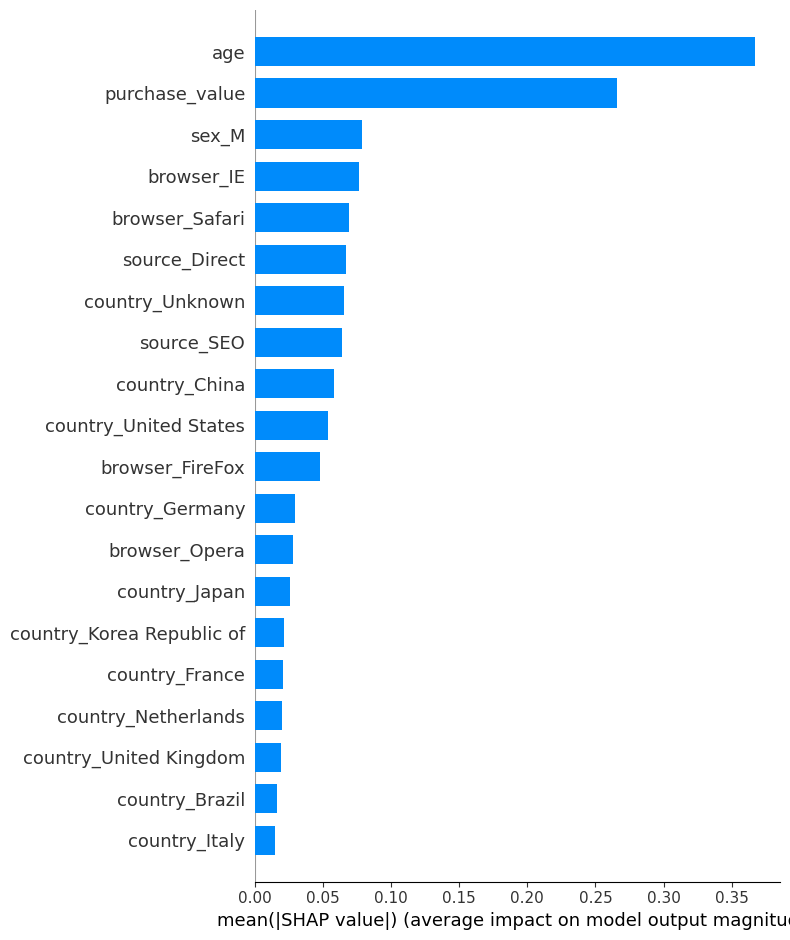

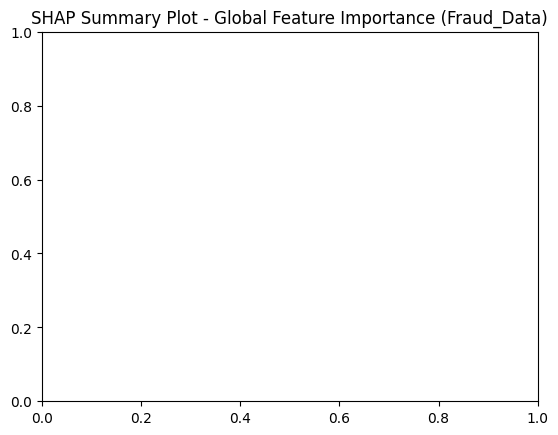

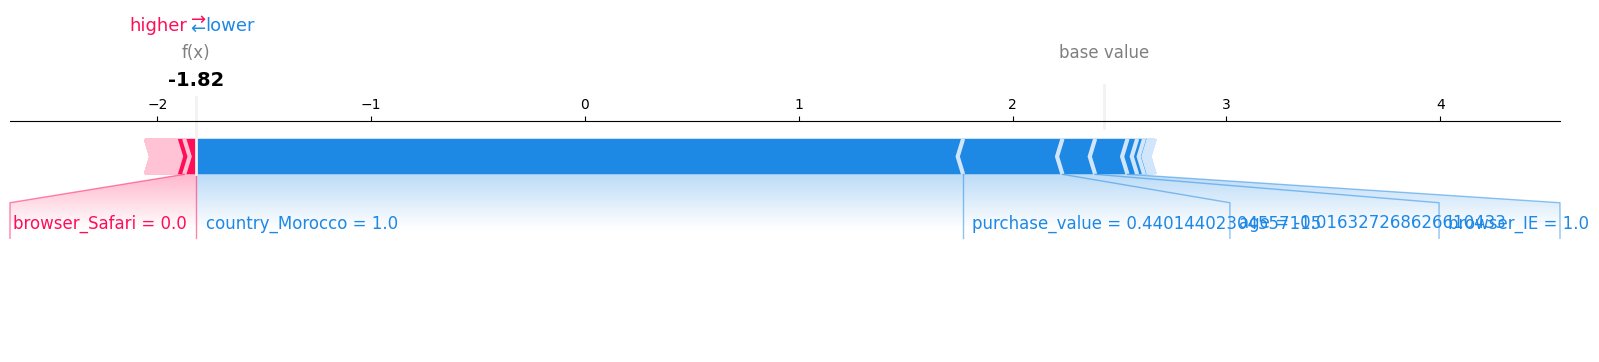

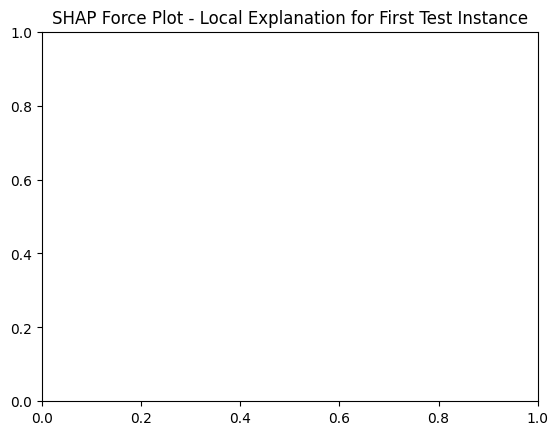

In [11]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_fraud)

# Get correct feature names from ColumnTransformer
feature_names = (preprocessor.named_transformers_['cat'].get_feature_names_out(fraud_categorical).tolist() + 
                 fraud_numerical)

# Summary Plot (global feature importance)
shap.summary_plot(shap_values, X_test_fraud, feature_names=feature_names, plot_type="bar")
plt.title("SHAP Summary Plot - Global Feature Importance (Fraud_Data)")
plt.show()

# Force Plot (local explanation for the first test instance)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_fraud[0,:], feature_names=feature_names, matplotlib=True)
plt.title("SHAP Force Plot - Local Explanation for First Test Instance")
plt.show()

## Final Report: Key Drivers of Fraud

### Insights from SHAP Plots
- **Summary Plot**: Based on the plot, the most influential features driving fraud predictions include `purchase_value` (with higher values strongly increasing fraud likelihood), followed by `country_Unknown` and `source_ads` (indicating transactions from unidentified regions or ad-driven sources are significant fraud indicators). `age` also ranks high, with older ages slightly decreasing fraud probability. The bar lengths reflect the magnitude of each feature's average impact across all predictions.
- **Force Plot**: For the first test instance, the plot shows a high `purchase_value` pushing the prediction toward fraud, while a lower `age` and a specific `country` (e.g., `country_US`) counteract this, resulting in a balanced prediction close to the base value. This suggests that extreme transaction amounts are decisive, moderated by user demographics.

### Conclusion
The SHAP analysis reveals that `purchase_value`, `country`-related features (especially `country_Unknown`), and `source_ads` are the primary drivers of fraud in the `Fraud_Data` dataset. The XGBoost model's ability to leverage these features, enhanced by SMOTE, supports its superior performance. These insights suggest focusing fraud prevention on high-value transactions from unidentified regions or ad-sourced users.